In [1]:
from __future__ import division, print_function

import netCDF4 as nc
import numpy as np

import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty, great_circle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
from mpl_toolkits import basemap
import warnings
from exceptions import KeyError
from netCDF4 import Dataset

from salishsea_tools import viz_tools
%matplotlib inline

In [2]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')
mask = mesh.variables['tmask'][0]
bathy = ma.array(mesh.variables['mbathy'][0],mask=(mask[0,:,:]-1)*-1)
zlevels=mesh.variables['gdept_0'][0]
lat=mesh.variables['nav_lat']
lon=mesh.variables['nav_lon']

In [3]:
grid = nc.Dataset('/home/jacquielee/data/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = grid.variables['Bathymetry'][:]
bathy = ma.masked_values(bathy[:],0)
bathy = ma.masked_where(bathy[:,:]>4500,bathy)

In [4]:
#state locations of output
control = '/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_'
control_storage = '/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/ANHA4-EXH005_'
stlandj = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/ANHA4-VJT002_'
polzin  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/ANHA4-VJT003_'

In [40]:
#nsquared
cnsq = ma.array(nc.Dataset(control_storage+'2012-2016avg_nsquare.nc').variables['nsquarefour'],mask=(mask-1)*-1)
pnsq = ma.array(nc.Dataset(polzin+'2012-2016avg_nsquare.nc').variables['nsquarefour'],mask=(mask-1)*-1)
sjnsq = ma.array(nc.Dataset(stlandj+'2012-2016avg_nsquare.nc').variables['nsquarefour'],mask=(mask-1)*-1)

# csal = ma.array(nc.Dataset(control_storage+'2012-2016avg_vosaline.nc').variables['vosalinefour'],mask=(mask-1)*-1)
# psal = ma.array(nc.Dataset(polzin+'2012-2016avg_vosaline.nc').variables['vosalinefour'],mask=(mask-1)*-1)
# sjsal = ma.array(nc.Dataset(stlandj+'2012-2016avg_vosaline.nc').variables['vosalinefour'],mask=(mask-1)*-1)

ctemp = ma.array(nc.Dataset(control_storage+'2012-2016avg_votemper.nc').variables['votemperfour'],mask=(mask-1)*-1)
ptemp = ma.array(nc.Dataset(polzin+'2012-2016avg_votemper.nc').variables['votemperfour'],mask=(mask-1)*-1)
sjtemp = ma.array(nc.Dataset(stlandj+'2012-2016avg_votemper.nc').variables['votemperfour'],mask=(mask-1)*-1)

ckappa = ma.array(nc.Dataset(control_storage+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'],3)
pkappa = ma.array(nc.Dataset(polzin+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'],mask=(mask-1)*-1)
sjkappa = ma.array(nc.Dataset(stlandj+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'],mask=(mask-1)*-1)

In [6]:
A = [690,210]
B = [652,170]
C = [627,145]
D = [545,160]
E = [525,175]
F = [500,200]

In [7]:
#Plot out the CAA transect

labels = ['A','B','C','D','E','F','G']
lons = [lon[A[0],A[1]],lon[B[0],B[1]],lon[C[0],C[1]],lon[D[0],D[1]],
        lon[E[0],E[1]],lon[F[0],F[1]]]
lats = [lat[A[0],A[1]],lat[B[0],B[1]],lat[C[0],C[1]],lat[D[0],D[1]],
        lat[E[0],E[1]],lat[F[0],F[1]]]

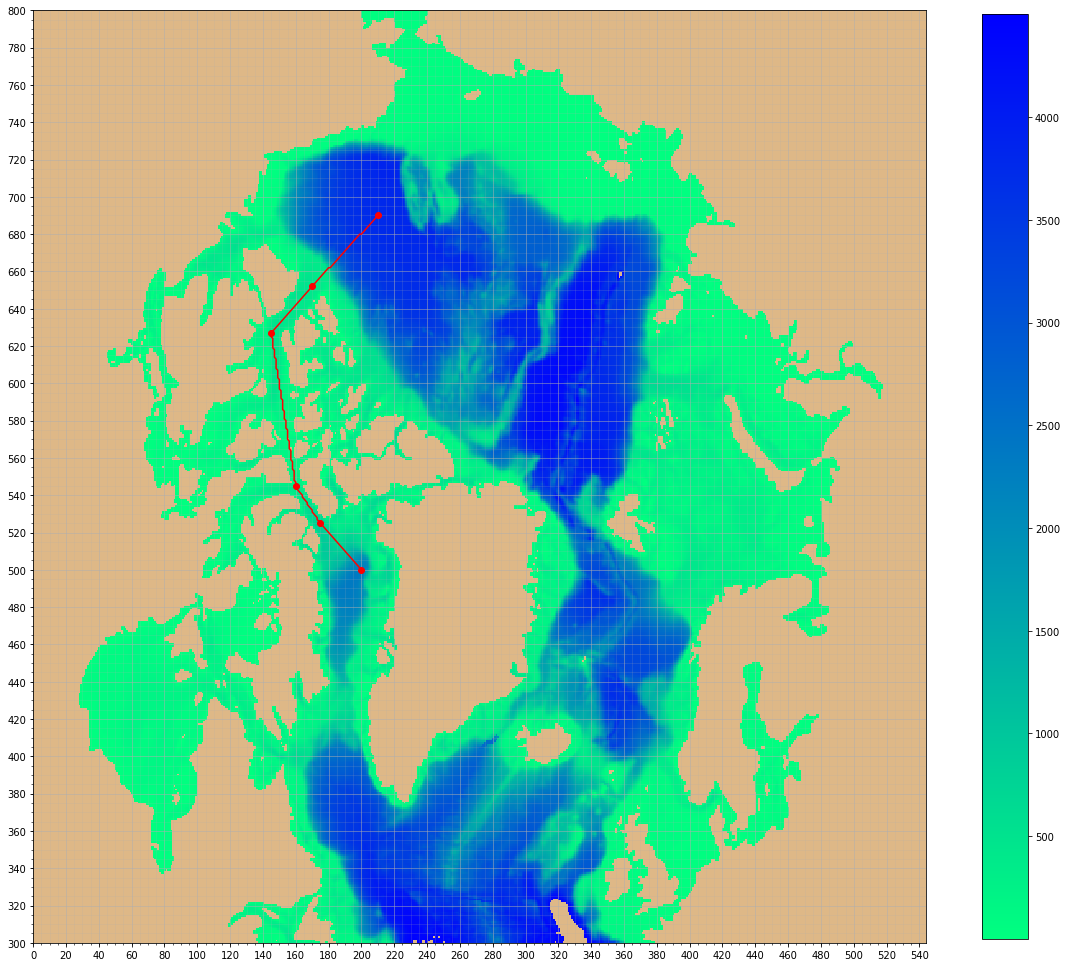

In [12]:
#zooming in
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('winter_r')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(bathy, cmap=cmap)
#shrink colourbar
fig.colorbar(mesh,shrink=0.85)

major_ticksx = np.arange(0,545,20)
minor_ticksx = np.arange(0,545,5)
major_ticksy = np.arange(300,801,20)
minor_ticksy = np.arange(300,801,5)

ax.set_xticks(major_ticksx)
ax.set_yticks(major_ticksy)

ax.set_xticks(minor_ticksx,minor=True)
ax.set_yticks(minor_ticksy,minor=True)
plt.plot(A[1],A[0], marker='o',color='red')
plt.plot(B[1],B[0], marker='o',color='red')
plt.plot(C[1],C[0], marker='o',color='red')
plt.plot(D[1],D[0], marker='o',color='red')
plt.plot(E[1],E[0], marker='o',color='red')
plt.plot(F[1],F[0], marker='o',color='red')
plt.plot(transx,transy,color='red')
plt.axis((0, bathy.shape[1], 300, 800))
ax.grid(which='both')
ax.grid(which='minor',alpha=0.2)
ax.grid(which='major',alpha=0.5)

In [8]:
G = [780,240]
H = [480,420]


In [9]:
#need to create transect with grid points. 
#first need to calculate the differences
#The full transects (with all the turning points) should be in one array

CAA= np.array(([690,210],[652,170],[627,145],[545,160],[525,175],[500,200]))
#CAA = np.array(([780,240],[480,420]))
transx = []
transy = []

for i in np.arange(0,len(CAA[:,0])-1):
    delx = CAA[i,1] - CAA[i+1,1]
    dely = CAA[i,0] - CAA[i+1,0]
    if delx > dely:
        if delx > 0:
            xval = np.arange(CAA[i,1],CAA[i+1,1],-1)
        else:
            xval = np.arange(CAA[i,1],CAA[i+1,1],1)
            
        slope = dely/delx
        b = CAA[i,0] - slope*CAA[i,1]
        yval = (slope*xval) + b
        yval = np.around(yval).astype(np.int)
    else:
        if dely > 0:
            yval = np.arange(CAA[i,0],CAA[i+1,0],-1)
        else:
            yval = np.arange(CAA[i,0],CAA[i+1,0],1)
            
        slope = dely/delx
        invslope = delx/dely
        b = CAA[i,0] - slope*CAA[i,1]
        xval =(yval-b)*invslope
        xval = np.around(xval).astype(np.int)
        
    
        
    transx.extend(xval[:])
    transy.extend(yval[:])
        
    

In [10]:
#Bering to scandinavia
starty = 799
startx = 100
length = 400

BerScan = ['G','H','I']

In [11]:
#function to create the bering strait transect
def create_transect(starty, startx, length, var,mask):
    CanSib = np.zeros((50,length))
    CanSib_mask = np.zeros((50,length))
    label = np.zeros((length))
    Blons = np.zeros((length))
    Blats = np.zeros((length))

    for i in range(0,length):
        CanSib[:,i] = var[:,starty-i,startx+i]
        CanSib_mask[:,i] = mask[:,starty-i,startx+i]
        Blons[i] = lon[starty-i,startx+i]
        Blats[i] = lat[starty-i,startx+i]
      
        #label[i] = lat[starty+i,startx+i]
        
    CanSib = ma.array(CanSib[::],mask=(CanSib_mask-1)*-1)
    return CanSib, Blons, Blats


In [49]:

# Bertranc, Blons, Blats = create_transect(799,100,400,ckappa,mask)
# Bertransj, Blons, Blats = create_transect(799,100,400,sjkappa,mask)
# Bertranp, Blons, Blats = create_transect(799,100,400,pkappa,mask)

#Bertranc, Blons, Blats = create_transect(799,100,400,csal,mask)
#Bertransj, Blons, Blats = create_transect(799,100,400,sjsal,mask)
#Bertranp, Blons, Blats = create_transect(799,100,400,psal,mask)

Bertranc, Blons, Blats = create_transect(799,100,400,ctemp,mask)
Bertransj, Blons, Blats = create_transect(799,100,400,sjtemp,mask)
Bertranp, Blons, Blats = create_transect(799,100,400,ptemp,mask)

# Bertranc, Blons, Blats = create_transect(799,100,400,cnsq,mask)
# Bertransj, Blons, Blats = create_transect(799,100,400,sjnsq,mask)
# Bertranp, Blons, Blats = create_transect(799,100,400,pnsq,mask)

In [50]:
#calculate along strack distance
alongtrack = np.zeros(length,dtype=int)
distance = 0
for index in np.arange(0,length-1):
    start = (Blats[index],Blons[index])
    end = (Blats[index+1],Blons[index+1])
    distance = distance + round(vincenty(start, end).kilometers)
    #round to the nearest 5 to make the labesl cleaner
    alongtrack[index+1] = int(round(distance/5.0)*5.0)

In [14]:
#alongtrack

In [15]:
alongtrack[::44]
alongtrack[-1]

7240

<function matplotlib.pyplot.show>

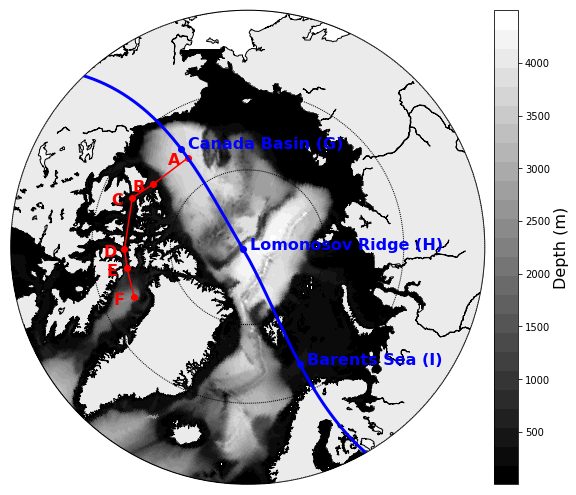

In [26]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round='True',ax=ax)
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(60.,90.,10.),labels=['60N','70N','80N'])
x_lon,y_lat=m(lon[:,:],lat[:,:])
cmap = plt.get_cmap('gray',25)
mesh = m.pcolor(x_lon[:,:], y_lat[:,:],bathy[:,:],cmap=cmap)

m.plot(lons,lats,marker='o',color='red',latlon=True)
x,y = m(lons,lats)
for label, xpt,ypt in zip(labels,x,y):
    plt.text(xpt-300000,ypt-100000,label,color='red',fontsize='16',weight='bold')
    

Blabels = ['Canada Basin (G) ','Lomonosov Ridge (H) ','Barents Sea (I)']
xx,yy = m(Blons[100::100],Blats[100::100])
m.plot(Blons,Blats,color='blue',latlon=True,linewidth=3)
for label, xpt,ypt in zip(Blabels,xx,yy):
    plt.text(xpt+100000,ypt+100,label,color='blue',fontsize='16',weight='bold')
    plt.scatter(xpt,ypt,marker='o',color='blue')
cb = m.colorbar(mesh)
cb.set_label(label = 'Depth (m)',fontsize=16)

plt.show

## Plot the CanBar transect

In [16]:
sal_bounds = np.array([29,30,33.6,33.8,34,34.1,34.4,34.6,34.75,34.85,34.9,34.93,34.96,35,35.2])
sal_bounds_anom = np.array([-1.0,-0.7,-0.4,-0.3,-0.2,-0.1,-0.05,-0.01,0.0,0.01,0.05,0.1,0.2,0.3,0.4,0.7,1.0])

In [27]:
kappa_bounds = np.array([ -10**-3,-10**-4,-10**-5,-10**-6,0.0,10**-6,10**-5,10**-4,10**-3])
kappa_labels = [r'${-10^{-3}}$',r'${-10^{-4}}$',r'${-10^{-5}}$',r'${-10^{-6}}$','0',
                r'${10^{-6}}$',r'${10^{-5}}$',r'${10^{-4}}$',r'${10^{-3}}$']

In [18]:
nsq_bounds = np.array([ -10**-3,-10**-4,-10**-5,-10**-6,-10**-7,-10**-8,0.0,10**-8,10**-7,10**-6,10**-5,10**-4,10**-3])
nsq_labels = [r'${-10^{-3}}$',r'${-10^{-4}}$',r'${-10^{-5}}$',r'${-10^{-6}}$',r'${-10^{-7}}$',r'${-10^{-8}}$','0',
               r'${10^{-8}}$',r'${10^{-7}}$', r'${10^{-6}}$',r'${10^{-5}}$',r'${10^{-4}}$',r'${10^{-3}}$']

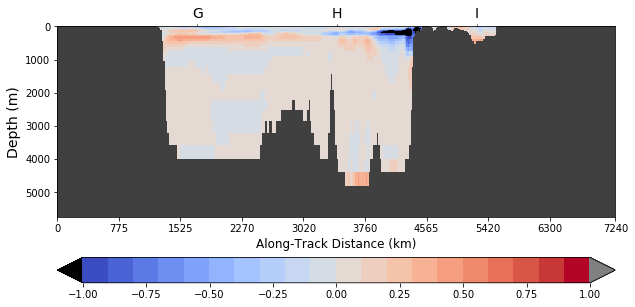

In [54]:
#Pick which variable s = salinity , t = temperature, k = kappa, n = stratification so appropriate scaling is used
variable = 't'
anomaly = True

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, )

x = np.arange(0,400)
y = zlevels[:]
X, Y = np.meshgrid(x[:], y[:])

#create colormap
if anomaly == True:
    cmap = plt.get_cmap('coolwarm',20)
else:
    cmap = plt.get_cmap('viridis',20)
cmap.set_bad('0.25',alpha=None)
cmap.set_over(color='grey')
cmap.set_under(color='black')
if variable == 'n':
    if anomaly == True:
        norm = mpl.colors.BoundaryNorm(nsq_bounds, cmap.N)
        label=r'${N^2}$'+' Anomaly (s$^{-2}$)'
    else:
        norm = colors.LogNorm(vmin=10**-8, vmax=10**-3)

elif variable == 'k':
    if anomaly == True:
        norm = mpl.colors.BoundaryNorm(kappa_bounds, cmap.N)
        label = '$K_{vfull}$ Anomaly'
    else:
        norm = colors.LogNorm(vmin=10**-6, vmax=10**-2)
        label = '$K_{vfull} ($\frac{m^{2}}{s}$)$'
        
elif variable == 's':
    if anomaly == True:
        norm = mpl.colors.BoundaryNorm(sal_bounds_anom, cmap.N)
        label = 'Salinity Anomaly'
        ticks=sal_bounds_anom[:]
    else:
        norm = mpl.colors.BoundaryNorm(sal_bounds, cmap.N)
        label = 'Salinity'
        ticks=sal_bounds[:]
        
elif variable == 't':
    if anomaly == True:
        norm = colors.Normalize(vmin=-1, vmax=1)
        label = 'Temperature Anomaly ($^\circ$C)'
    else:
        norm = colors.Normalize(vmin=-1.8, vmax=4)
        label = 'Temperature ($^\circ$C)'

mesh = ax.pcolormesh(X,Y,Bertransj-Bertranp,cmap=cmap,norm=norm)

#flip plot
plt.ylim(zlevels[0],zlevels[-1])
ax.set_ylim(ax.get_ylim()[::-1])


import matplotlib.ticker as ticker
tick = [100,200,300]
ax.xaxis.set_minor_locator(ticker.FixedLocator(tick))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(BerScan))
plt.gca().tick_params(axis="x", which="minor", direction="out", 
                       top=1, bottom=0, labelbottom=0, labeltop=1,labelsize=14)

ax.set_xticks(np.array([  0,  44,  88, 132, 176, 220, 264, 308, 352, 399]))
ax.set_xticklabels(np.array([   0,  775, 1525, 2270, 3020, 3760, 4565, 5420, 6300,7240]),color='black')
ax.set_xlabel('Along-Track Distance (km)',fontsize = 12,color='black')
# ax.set_xticklabels(BerScan,fontsize=14)
ax.set_ylabel('Depth (m)', fontsize=14)

#axR.set_xticks(alongtrack[::50])

#ax.set_xticklabels(CanSiblabel)
bar = plt.colorbar(mesh,orientation='horizontal',extend='both')# ,label='Buoyancy Frequency ('+r'${N^2}$'+')',labelsize=18)
#bar = plt.colorbar(mesh,orientation='horizontal')# ,ticks=nsq_bounds)

#bar.set_ticklabels(nsq_labels)



#bar.set_label(label, fontsize=14)
#bar.ax.tick_params(labelsize=14)
bar.update_ticks()

In [38]:
#create CAA transect function
def create_transect2(xcoord,ycoord,var,mask):

    transect = np.zeros((50, len(xcoord)))
    trans_mask = np.zeros((50, len(xcoord)))
    for i in np.arange(0,len(xcoord)):

        transect[:,i] = var[:,ycoord[i],xcoord[i]]
        trans_mask[:,i] =  mask[:,ycoord[i],xcoord[i]]

    transect = ma.array(transect[::],mask=(trans_mask-1)*-1)
    return transect    
    
    

In [41]:
cCAA = create_transect2(transx,transy,ctemp,mask)
sjCAA = create_transect2(transx,transy,sjtemp,mask)
pCAA = create_transect2(transx,transy,ptemp,mask)

In [188]:
sal_bounds = np.array([29,30,33.6,33.8,34,34.1,34.4,34.6,34.75,35])

In [79]:
# kappa_bounds = np.array([-10**-2, -10**-3,-10**-4,-10**-5,-10**-6,0.0,10**-6,10**-5,10**-4,10**-3,10**-2])
# kappa_labels = ['-10^-2', '-10^-3','-10^-4','-10^-5','-10^-6','0','10^-6','10^-5','10^-4','10^-3','10^-2']

kappa_bounds = np.array([ -10**-3,-10**-4,-10**-5,-10**-6,0.0,10**-6,10**-5,10**-4,10**-3])
kappa_labels = [r'${-10^{-3}}$',r'${-10^{-4}}$',r'${-10^{-5}}$',r'${-10^{-6}}$','0',
                r'${10^{-6}}$',r'${10^{-5}}$',r'${10^{-4}}$',r'${10^{-3}}$']

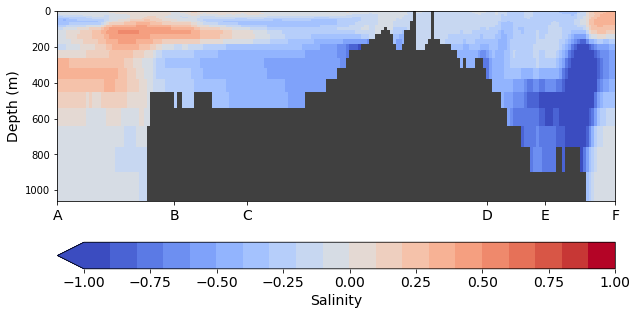

In [48]:
#This method to plot temperature and kappa only
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
x = np.arange(0,192)
y = zlevels[:45]
#x = np.arange(0,300)
#y = zlevels[:]
X, Y = np.meshgrid(x[:], y[:])

#create colormap
#cmap = shiftedColorMap( plt.get_cmap('coolwarm',20),midpoint=0.857)
#cmap = plt.get_cmap('viridis',20)
cmap = plt.get_cmap('coolwarm',20)
cmap.set_bad('0.25',alpha=None)
#cmap.set_over(color='grey')
#cmap.set_under(color='black')
norm = colors.Normalize(vmin=-1.0, vmax=1.0)
#norm = colors.LogNorm(vmin=10**-6, vmax=10**-3)
#norm = colors.Normalize(vmin=-1.8, vmax=2.0)
#norm = mpl.colors.BoundaryNorm(kappa_bounds, cmap.N)
#norm = mpl.colors.BoundaryNorm(sal_bounds, cmap.N)
mesh = ax.pcolormesh(X,Y,sjCAA[:45,:]-pCAA[:45,:],cmap=cmap,norm=norm)

#flip plot
plt.ylim(zlevels[0],zlevels[35])
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xticks([0,40,65,147,167,191])
ax.set_xticklabels(['A','B','C','D','E','F'],fontsize=14)
bar = plt.colorbar(mesh,orientation='horizontal',extend='min')# ,label='Buoyancy Frequency ('+r'${N^2}$'+')',labelsize=18)
#bar = plt.colorbar(mesh,orientation='horizontal' ,ticks = [-1.25,-1.0,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1.0,1.25])#sal_bounds[:])
#bar.set_ticklabels(kappa_labels)
#label = 'Conservative Temperature Anomaly ($^\circ$C)'
#label='Buoyancy Frequency ('+r'${N^2}$'+')'
#label = '$K_v$'
label = 'Salinity'
bar.set_label(label, fontsize=14)
bar.ax.tick_params(labelsize=14)
ax.set_ylabel('Depth (m)',fontsize=14)
bar.update_ticks()

In [42]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap